In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [4]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 2
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
#epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
#epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [5]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    #df = pd.read_csv("../../raw_data/BaselineCarbon_2015.csv", index_col=['regionbase'],header='infer')
    #df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
    df = pd.read_excel("../../raw_data/baselinecarbon_direct_2018.xlsx", index_col = 0)
#df['CeHH'] = df['CeHH_old']
#df['Cec'] = 0
#df['CeFF'] = df['CeFF_old']
#df['Cecstar'] = 0
df['jxbar']=df['Cex']/(df['Cex'] + df['Ceystar'])
df['jmbar']=df['Cey']/(df['Cey'] + df['Cem'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[(df['region_scenario'] == 3)]
#df = df[df['region_scenario'] != 4]
df

,region_scenario,Qe,Qestar,Qeworld,CeHH_old,Cem,Cex,CeFF_old,Ce,Cestar,...,Gestar,Ceworld,Geworld,Ced,Cedstar,Cey,Ceystar,World total Cec,jxbar,jmbar
regionbase,,,,,,,,,,,,,,,,,,,,,
OECD37 as Home,3,9.30397,24.33133,33.6353,11.2795,2.4744,1.0261,18.8553,13.7539,19.8814,...,21.3297,33.6353,33.6353,2.5272,2.1635,8.7523,16.6918,4.6907,0.057913,0.779597


In [6]:
tax_scenario= pd.DataFrame({'tax_sce': ['purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid', 'EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['global']})
#tax_scenario= pd.DataFrame({'tax_sce': ['EP_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp']})

In [7]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,5,0.1)
    #varphilist = np.arange (0,1,0.2)
    #varphilist = [0,1,2]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [8]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [9]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
purete
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
puretc
0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000

In [10]:
output_list=[]
for i in range(0,len(tax_scenario)):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,leak,leakstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,purete,OECD37 as Home,0.0,1.000000,0.000000,1.000000,0.000000,0.057913,0.779597,0.057913,...,0.0,0.0,-0.000003,-0.000003,9.303970,24.331331,0.0,0.0,3.0,1.0
1,purete,OECD37 as Home,0.1,1.002199,0.000000,1.000000,0.040711,0.057913,0.779597,0.057913,...,0.0,0.0,0.004922,-0.004938,9.123053,24.438451,0.0,0.0,3.0,1.0
2,purete,OECD37 as Home,0.2,1.004423,0.000000,1.000000,0.081101,0.057913,0.779597,0.057913,...,0.0,0.0,0.019745,-0.019834,8.940150,24.547037,0.0,0.0,3.0,1.0
3,purete,OECD37 as Home,0.3,1.006673,0.000000,1.000000,0.121166,0.057913,0.779597,0.057913,...,0.0,0.0,0.044528,-0.044847,8.755164,24.657161,0.0,0.0,3.0,1.0
4,purete,OECD37 as Home,0.4,1.008952,0.000000,1.000000,0.160903,0.057913,0.779597,0.057913,...,0.0,0.0,0.079353,-0.080135,8.567987,24.768892,0.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,EPC_hybrid,OECD37 as Home,4.5,0.978520,3.155075,0.708797,4.500000,0.039679,0.779597,0.025242,...,0.193158509238858,0.708796934245070,41.408853,-20.748109,0.000000,23.297262,0.0,0.0,3.0,1.0
46,EPC_hybrid,OECD37 as Home,4.6,0.977728,3.222785,0.712290,4.600000,0.039569,0.779597,0.024994,...,0.194510815366498,0.712289895661046,42.792654,-20.977055,0.000000,23.259599,0.0,0.0,3.0,1.0
47,EPC_hybrid,OECD37 as Home,4.7,0.976962,3.290463,0.715700,4.700000,0.039462,0.779597,0.024753,...,0.195857647349933,0.715700026591816,44.181395,-21.203465,0.000000,23.223155,0.0,0.0,3.0,1.0
48,EPC_hybrid,OECD37 as Home,4.8,0.976220,3.358112,0.719030,4.800000,0.039358,0.779597,0.024518,...,0.197199076529391,0.719030230190123,45.574935,-21.427378,0.000000,23.187871,0.0,0.0,3.0,1.0


In [11]:
Outcomes[['pe','tb', 'Ced_prime', 'Cedstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vg_prime']]

,pe,tb,Ced_prime,Cedstar_prime,Cey_prime,Cex_prime,Cem_prime,Ceystar_prime,Vg_prime
0,1.000000,0.000000,2.527200,2.163500,8.752300,1.026100,2.474400,16.691800,74.844667
1,1.002199,0.000000,2.521655,2.158753,8.733097,1.023849,2.468971,16.655177,74.844667
2,1.004423,0.000000,2.516072,2.153973,8.713760,1.021582,2.463504,16.618299,74.844667
3,1.006673,0.000000,2.510447,2.149158,8.694279,1.019298,2.457997,16.581147,74.844667
4,1.008952,0.000000,2.504778,2.144305,8.674647,1.016996,2.452447,16.543706,74.844667
...,...,...,...,...,...,...,...,...,...
45,0.978520,3.155075,0.611381,2.210993,2.117358,0.370547,0.598607,17.388375,74.844667
46,0.977728,3.222785,0.601641,2.212782,2.083626,0.368027,0.589071,17.404451,74.844667
47,0.976962,3.290463,0.592207,2.214518,2.050956,0.365594,0.579834,17.420045,74.844667
48,0.976220,3.358112,0.583066,2.216202,2.019296,0.363244,0.570884,17.435179,74.844667


In [28]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb','te','varphi', 'Qe_prime', 'Qeworld_prime','delta_Vg','delta_Vgstar','delta_Le','delta_Lestar','delta_UCec', 'delta_UCecstar','welfare','welfare_noexternality']]

,pe,tb,te,varphi,Qe_prime,Qeworld_prime,delta_Vg,delta_Vgstar,delta_Le,delta_Lestar,delta_UCec,delta_UCecstar,welfare,welfare_noexternality
0,1.000000,0.000000,0.000000,0.0,4.711400,33.635300,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
6,0.996610,0.067608,0.100000,0.1,4.626340,33.354472,-0.290450,0.052792,-0.083533,-0.195437,-0.066852,0.012281,0.045974,-0.044293
12,0.993727,0.134835,0.200000,0.2,4.539995,33.102151,-0.564397,0.096326,-0.165245,-0.360610,-0.129906,0.022759,0.177490,-0.165254
18,0.991271,0.201765,0.300000,0.3,4.452300,32.873469,-0.823660,0.132020,-0.245112,-0.500540,-0.189580,0.031707,0.386188,-0.348446
24,0.989180,0.268466,0.400000,0.4,4.363189,32.664570,-1.069780,0.161005,-0.323109,-0.619157,-0.246229,0.039344,0.665125,-0.582973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.903308,6.391367,6.391367,9.5,5.300711,28.195142,-15.399973,1.621733,-0.263009,-4.918254,-1.384679,0.276653,81.246937,-18.784364
581,0.903174,6.457633,6.457633,9.6,5.300318,28.187962,-15.469915,1.624051,-0.263364,-4.924384,-1.387510,0.277056,82.310273,-18.907398
587,0.903042,6.523896,6.523896,9.7,5.299932,28.180910,-15.539230,1.626328,-0.263712,-4.930404,-1.390294,0.277452,83.374967,-19.029449
593,0.902913,6.590156,6.590156,9.8,5.299553,28.173986,-15.607931,1.628565,-0.264054,-4.936314,-1.393033,0.277841,84.440938,-19.150538


In [16]:
Outcomes[['pe','tb','Lg_prime', 'Lgstar_prime']]

,pe,tb,Lg_prime,Lgstar_prime
0,1.000000,0.0,14.488533,149.530867
1,1.034469,0.0,14.488533,149.530867
2,1.071308,0.0,14.488533,149.530867
3,1.110659,0.0,14.488533,149.530867
4,1.152659,0.0,14.488533,149.530867
...,...,...,...,...
95,9.511055,0.0,14.488533,149.530867
96,9.610826,0.0,14.488533,149.530867
97,9.710605,0.0,14.488533,149.530867
98,9.810390,0.0,14.488533,149.530867


In [12]:
Outcomes.to_csv('../../output/direct_consumption_higheps_constrained.csv', header=True)

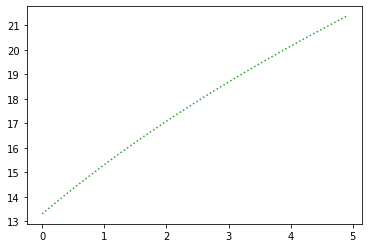

In [14]:
import matplotlib.pyplot as plt
df1 = Outcomes[Outcomes['varphi'] < 5]
df1['prop_energy'] = df1['Qe2_prime'] / df1['Qe_prime'].iat[0] * 100
x = 'varphi'
y = 'prop_energy'

df_plot = df1[df1['tax_sce'] == 'puretc']
plt.plot(df_plot['varphi'], df_plot['prop_energy'], linestyle='dotted', label = 'consumption tax',color = 'C2')

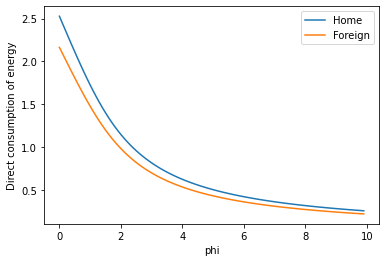

In [16]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Direct consumption of energy")
plt.legend()
#plt.savefig('phi_cec.pdf', format='PDF')

In [17]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

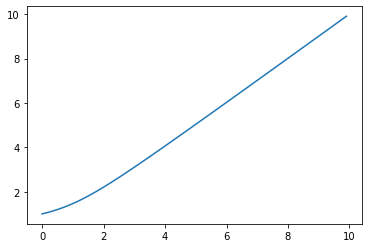

In [18]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

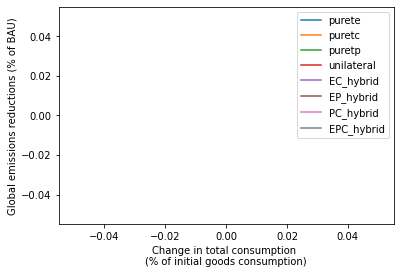

In [19]:
df = pd.read_csv('../../output_sig0/ces0.csv')
df = df[(df['region_scenario'] == 3) & (df['tax_sce'] == 'PC_hybrid') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100

df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'purete')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretc']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretc')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretp']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretp')

df_plot = Outcomes[Outcomes['tax_sce'] == 'Unilateral']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'unilateral')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EP_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EP_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'PC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'PC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EPC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EPC_hybrid')

#df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
#plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

#plt.savefig('wf_chg.pdf', format = 'PDF')

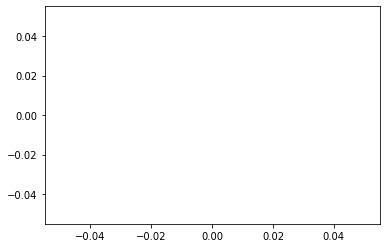

In [20]:
df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
#plt.plot(df_plot['varphi'], df_plot['Qeworld_prime'], label = 'purete')
df_plot['Ceworld_prime'] = df_plot['Cec_prime'] + df_plot['Cecstar_prime'] + df_plot['Cey_prime'] + df_plot['Cem_prime'] + df_plot['Cex_prime'] + df_plot['Ceystar_prime']
plt.plot(df_plot['varphi'], df_plot['Qe_prime'], label = 'purete')

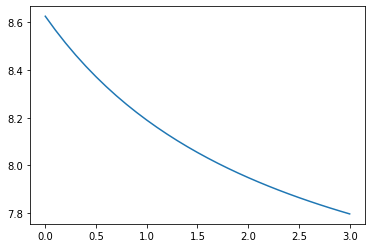

In [21]:
plt.plot(df['varphi'], df['Qe_prime'], label = 'purete')

In [22]:
df[['pe','tb', 'varphi','Cey_prime','Cex_prime','Vg_prime', 'Vgstar_prime', 'Vgx_prime', 'Vgm_prime']]

,pe,tb,varphi,Cey_prime,Cex_prime,Vg_prime,Vgstar_prime,Vgx_prime,Vgm_prime
3800,1.000000,0.000000,0.0,11.293670,0.910570,91.874733,123.298533,6.070467,16.5836
3801,0.986510,0.046870,0.1,10.928872,0.881510,91.874733,123.298533,5.969814,16.5836
3802,0.974072,0.092767,0.2,10.586111,0.854840,91.874733,123.298533,5.876343,16.5836
3803,0.962574,0.137787,0.3,10.263600,0.830295,91.874733,123.298533,5.789350,16.5836
3804,0.951920,0.182015,0.4,9.959712,0.807646,91.874733,123.298533,5.708214,16.5836
3805,0.942024,0.225526,0.5,9.672967,0.786693,91.874733,123.298533,5.632383,16.5836
3806,0.932810,0.268386,0.6,9.402023,0.767261,91.874733,123.298533,5.561372,16.5836
3807,0.924213,0.310653,0.7,9.145662,0.749198,91.874733,123.298533,5.494746,16.5836
3808,0.916176,0.352380,0.8,8.902777,0.732369,91.874733,123.298533,5.432121,16.5836
3809,0.908646,0.393613,0.9,8.672368,0.716658,91.874733,123.298533,5.373155,16.5836
